# Vertical distribution of hydrometeors

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import scipy.stats as stats
from numba import njit

%load_ext Cython

In [101]:
figpath = '../../plots/'

## 1. Data

In [2]:
# find all directories which have the same name in the folder in exp_path/icon_burga_v1 and exp_path/icon_burga_v0 and store the first 8 digits of the names in a list 
#exp_path = '/data/inscape/icon/experiments/nyalesund/testbed/'
exp_path='../../data/'
exp_name_v1 = 'exp_data_v1/'
exp_name_v0 = 'exp_data_v0/'

# find all directories which have the same name in the folder in exp_path/icon_burga_v1 and exp_path/icon_burga_v0 and store the first 8 digits of the names in a list
exp_dirs_v1 = glob.glob(exp_path+exp_name_v1+'*')
exp_dirs_v0 = glob.glob(exp_path+exp_name_v0+'*')
print(exp_dirs_v1)
# sort the lists
exp_dirs_v1.sort()
exp_dirs_v0.sort()

# create a list with the first 8 digits of the names which come after the last / in the directory names
exp_names_v1 = [exp_dir.split('/')[-1][19:27] for exp_dir in exp_dirs_v1]
exp_names_v0 = [exp_dir.split('/')[-1][19:27] for exp_dir in exp_dirs_v0]
print(exp_names_v1)

# compare the lists and find the common elements
exp_dates = list(set(exp_names_v1) & set(exp_names_v0))

print(len(exp_dates))
print(exp_dates)

['../../data/exp_data_v1/METEOGRAM_patch001_20210802_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211026_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210815_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211031_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210829_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211001_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211019_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210825_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211024_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211007_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211018_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211008_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210804_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210811_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211014_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch

In [4]:
# get names of datavariables in ds_v1 as list
#varnames = ds_v1.data_vars
#varnames = list(varnames.keys())
#print(varnames[])

In [3]:
# open all the files which are in the common elements list exp_dates
exp_dir_names_v0 = [exp_path+exp_name_v0+'/METEOGRAM_patch001_'+exp_date+'_awipev.nc' for exp_date in exp_dates]
exp_dir_names_v1 = [exp_path+exp_name_v1+'/METEOGRAM_patch001_'+exp_date+'_awipev.nc' for exp_date in exp_dates]

In [4]:
vars2ignore = list(['U', 'V', 'W', 'P', 'TKVM', 'TKVH', 'PHALF', 'T_SO', 'W_SO', 'W_SO_ICE', 'PL_COV',
                    'LA_IND', 'RO_DEPT', 'Z0', 'QV_S', 'W_I', 'W_SNOW', 'RUNOFF_S', 'RUNOFF_G', 'T_SNOW', 
                    'T_S', 'T_G', 'FRESHSNW', 'RHO_SNOW', 'H_SNOW', 'FR_SEAICE', 'P_SFC', 'TCM', 'TCH',
                    'SHFL', 'LHFL', 'VIO3', 'HMO3', 'T2M', 'TD2M', 'U10M', 'V10M', 'VBMAX10M', 'dyn_gust',
                    'con_gust', 'cape_ml', 'SOBT', 'THBT', 'SOBS', 'THBS', 'ALB', 'RAIN_GSP', 'SNOW_GSP',
                    'RAIN_CON', 'SNOW_CON', 'H_ICE', 'CLCT', 'CLCL', 'CLCM', 'CLCH', 'hbas_con', 'htop_con',
                    'UMFL_S', 'VMFL_S', 'SWDIFU_S', 'SWDIFD_S', 'PAB_S', 'SWDIR_S', 'TQV', 'TQC', 'TQI',
                    'TQR', 'TQS', 'TQV_DIA', 'TQC_DIA', 'TQI_DIA'])


In [7]:
# only read in the needed variables, makes it much faster
ds_v1 = xr.open_mfdataset(exp_dir_names_v1, combine='by_coords', parallel=True, drop_variables=vars2ignore)
ds_v0 = xr.open_mfdataset(exp_dir_names_v0, combine='by_coords', parallel=True, drop_variables=vars2ignore)

In [8]:
# remove the first three hours each day
ds_v1 = ds_v1.where(ds_v1.time.dt.hour >= 3, drop=True)
ds_v0 = ds_v0.where(ds_v0.time.dt.hour >= 3, drop=True)

In [9]:
# select only the first 100 layers of height and 99 layers of height_2 
ds_v1 = ds_v1.isel(height=slice(50,len(ds_v1.height)), height_2=slice(50,len(ds_v1.height_2)))
ds_v0 = ds_v0.isel(height=slice(50,len(ds_v0.height)), height_2=slice(50,len(ds_v0.height_2)))

### 1.2 Settings

In [10]:
color_v1 = "maroon"
color_v0 = "steelblue"

label_v1 = "SK-P"
label_v0 = "Hande"

### 1.3 Data subselection

Writing out numpy arrays takes quite long so this should only be done once


In [90]:
# create an array with shape (time, height_2,6) 
Q_all_hydro_v1 = np.stack((ds_v1['QC'].values,
                            ds_v1['QR'].values,
                            ds_v1['QG'].values,
                            ds_v1['QS'].values, 
                            ds_v1['QI'].values  
                            ), axis=-1)

In [91]:
Q_all_hydro_v0 = np.stack(( ds_v0['QC'].values,
                            ds_v0['QR'].values,
                            ds_v0['QG'].values, 
                            ds_v0['QS'].values, 
                            ds_v0['QI'].values,
                            ), axis=-1)

In [92]:
QN_all_hydro_v1 = np.stack((ds_v1['QNC'].values,
                            ds_v1['QNR'].values,
                            ds_v1['QNG'].values,
                            ds_v1['QNS'].values, 
                            ds_v1['QNI'].values,
                            ds_v1['NIACT']), axis=-1)


In [93]:
QN_all_hydro_v0 = np.stack(( ds_v0['QNC'].values,
                             ds_v0['QNR'].values,
                             ds_v0['QNG'].values,
                             ds_v0['QNS'].values, 
                             ds_v0['QNI'].values,
                             ds_v0['NIACT']), axis=-1)

In [15]:
T_v0 = ds_v0['T'].values

In [16]:
T_v1 = ds_v1['T'].values

#### 1.3.1 There are different ways to define a cloud

In [23]:
#only cloudy grid points
ds_v1.CLC.values[(ds_v1['QC'].values+ds_v1['QI'].values+
                  ds_v1['QS'].values+ds_v1['QR'].values+
                  ds_v1['QG'].values+ds_v1['QH'].values)>=1e-8].size


KeyboardInterrupt: 

In [10]:
#only cloudy grid points
ds_v1.CLC.values[(ds_v1['QC'].values+ds_v1['QI'].values)>=1e-8].size


11418622

In [11]:
ds_v1.CLC.values[ds_v1['CLC'].values == 1 ].size

11409851

#### 1.3.2 Select periods with clouds
Using my cloud definition to be consistent with other data analysis

In [17]:
# write code for jit
@njit
def calc_myCLC(Q_arr):
    myCLC = np.sum(Q_arr, axis=2)   #QC + QI + QS + QR + QG + QH
    for i in range(myCLC.shape[0]):
        for j in range(myCLC.shape[1]):
            if myCLC[i, j] < 1e-8:
                myCLC[i, j] = 0
            else:
                myCLC[i, j] = 1
    return myCLC

In [ ]:
np.sum(Q_all_hydro_v1, axis=2).shape

(504000, 100)

In [18]:
myCLC_v1 = calc_myCLC(Q_all_hydro_v1) #, QI_v1, QS_v1, QR_v1, QG_v1, QH_v1)
myCLC_v0 = calc_myCLC(Q_all_hydro_v0) #QC_v0, QI_v0, QS_v0, QR_v0, QG_v0, QH_v0)

In [19]:
ds_v0['My_CLC'] = (('time', 'height_2'), myCLC_v0)
ds_v1['My_CLC'] = (('time', 'height_2'), myCLC_v1)

In [25]:
# This alternative formulation can be faster but also very slow and uses xarray which I am trying to avoid now to speed up the code
# copy CLC to a new variable and set all values to 0
#ds_v1['My_CLC'] = ds_v1.CLC
#
#ds_v1['My_CLC'].values = (ds_v1['QC'].values+ds_v1['QI'].values+
#                  ds_v1['QS'].values+ds_v1['QR'].values+
#                  ds_v1['QG'].values+ds_v1['QH'].values)>=1e-8
# do same for v0
#ds_v0['My_CLC'] = ds_v0.CLC

#ds_v0['My_CLC'].values = (ds_v0['QC'].values+ds_v0['QI'].values+
#                    ds_v0['QS'].values+ds_v0['QR'].values+
#                    ds_v0['QG'].values+ds_v0['QH'].values)>=1e-8

#### 1.3.3 Create temperature binned values


In [20]:
# remove values which are clear sky my_CLC == 0
T_v0_cloudy= T_v0[myCLC_v0 != 0]
T_v1_cloudy= T_v1[myCLC_v1 != 0]

In [28]:
T_v0_cloudy.shape

(14696160,)

In [21]:
T_bins = np.arange(int(np.min((T_v0_cloudy.min(),T_v1_cloudy.min()))), int(np.max((T_v0_cloudy.max(), T_v1_cloudy.max()))), 1)

In [23]:
# create an array which contains the bin number for each temperature value
T_v0_bin = np.digitize(T_v0_cloudy, T_bins)
T_v1_bin = np.digitize(T_v1_cloudy, T_bins)

In [57]:
# compute the mean of the QC values for each bin
@njit
def get_mean_QN(QN, T_bin_cloudy, T_bins, limit=1e-8):
    QN_bin_mean = np.zeros(len(T_bins))

    n = 0 # counter for the number of values in the bin
    QN_sum = 0 # sum of all values in the bin
    for i in range(len(T_bins)):
        n = np.sum(T_bin_cloudy == i)
        QN_sum = np.sum(QN[(T_bin_cloudy == i) & (QN > limit)])
        if n == 0:
            QN_bin_mean[i] = np.nan
        else:
            QN_bin_mean[i] = QN_sum/n
    return QN_bin_mean
#QC_bin_mean_v0 = np.array([QC_v0_cloudy[T_v0_bin == i].mean() for i in range(1, len(T_bins))])

# get interquartile range for each bin
@njit
def get_iqr_QN(QN, T_bin_cloudy, T_bins, limit=1e-8):
    QN_bin_iqr = np.zeros((len(T_bins), 2))

    for i in range(len(T_bins)):
        QN_bin = QN[(T_bin_cloudy == i) & (QN > limit)]
        if QN_bin.size > 0:
            Q1 = np.percentile(QN_bin, 25)
            Q3 = np.percentile(QN_bin, 75)
            QN_bin_iqr[i,1] = Q3 
            QN_bin_iqr[i,0] = Q1
    return QN_bin_iqr

@njit
def median(arr):
    # Sort the array
    sorted_arr = np.sort(arr)
    length = len(sorted_arr)

    # Compute the median
    if length % 2 == 1:
        return sorted_arr[length // 2]
    else:
        return 0.5 * (sorted_arr[length // 2 - 1] + sorted_arr[length // 2])
    
# create similar function to get median
@njit
def get_median_QN(QN, T_bin_cloudy, T_bins):
    QN_bin_median = np.zeros(len(T_bins))

    for i in range(len(T_bins)):
        #QN_bin = List()
        #for j in range(len(QN)):
         #   if T_bin_cloudy[j] == i and QN[j] > limit:
         #       QN_bin.append(QN[j])
        #if len(QN_bin) > 0:
        #    QN_bin_median[i] = median(np.array(QN_bin))
        QN_bin_median[i] = median(QN[(T_bin_cloudy == i)])
    return QN_bin_median


In [37]:
selvar = QN_all_hydro_v0[:,:,0][(myCLC_v0 != 0)] 
selT = T_v0_bin[selvar > 1]
selvar = selvar[selvar > 1]

In [39]:
selvar.shape
selT.shape

(2851407,)

In [48]:
get_median_QN(selvar, selT, T_bins)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


array([5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 5.80543088e-310, 5.80543088e-310,
       5.80543088e-310, 5.80543088e-310, 4.42492027e+007, 9.07094239e+007,
       9.18616657e+007, 9.39364991e+007, 7.33833329e+007, 1.82482357e+008,
       1.06136859e+008, 6.52054269e+007, 7.22029383e+007, 9.36555985e+007,
       1.19595601e+008, 1

In [125]:
get_median_QN(QC_v0_cloudy, T_v0_bin, T_bins)

array([4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 4.08983768e-307, 4.08983768e-307,
       4.08983768e-307, 4.08983768e-307, 1.47242260e-007, 1.48689549e-005,
       3.32023856e-005, 2.82501412e-004, 2.35527757e-004, 1.14113292e-004,
       6.04692704e-005, 4.57286958e-005, 5.15474283e-005, 4.64292473e-005,
       6.90276021e-005, 6

In [120]:
get_iqr_QN(QC_v0_cloudy, T_v0_bin, T_bins)

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.000000

In [102]:
get_mean_QN(QC_v0_cloudy, T_v0_bin, T_bins)

array([           nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.09118995e-11, 3.42218179e-08,
       4.52640724e-07, 5.71172393e-07, 6.09333104e-07, 1.27057619e-06,
       7.99495178e-07, 1.67232462e-06, 3.71208939e-06, 5.48568893e-06,
       6.22575978e-06, 1.13792547e-05, 1.31111164e-05, 2.06650453e-05,
      

## 2. Analysis

### 2.1 Vertical distribution

In [13]:
var = 'NIACT'
#xlabel_text = 'cloud droplet concentration (1/kg)'
#xlabel_text = 'cloud ice concentration (1/kg)'
#xlabel_text = 'snow concentration (1/kg)'
#xlabel_text = 'rain concentration (1/kg)'
#xlabel_text = 'graupel concentration (1/kg)'
xlabel_text = 'Number of activated ice nuclei (1/kg)'

In [14]:
QN_v1 = ds_v1[var].where(ds_v1[var] > 1, drop=True)
QN_v0 = ds_v0[var].where(ds_v0[var] > 1, drop=True)

QN_v1

<xarray.DataArray 'NIACT' (time: 328730, height_2: 100)>
dask.array<where, shape=(328730, 100), dtype=float64, chunksize=(8400, 100), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2021-08-02T17:46:48 ... 2021-10-31T23:59:51
  * height_2  (height_2) float64 1.008e+04 9.919e+03 9.761e+03 ... 44.98 20.2
Attributes:
    name:       NIACT
    long_name:  number concentration activated ice nuclei
    unit:       kg-1
    group_id:   1
    nlevs:      150

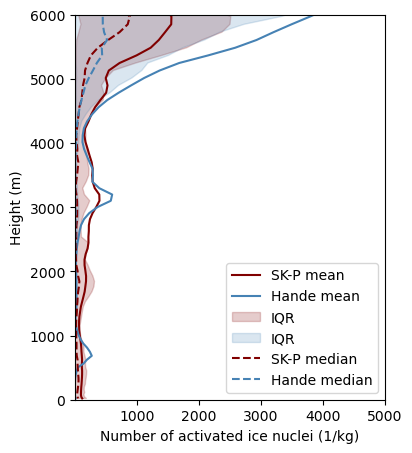

In [17]:
# rechunk to avoid memory error
QN_v1 = QN_v1.chunk(dict(time=-1))
QN_v0 = QN_v0.chunk(dict(time=-1))

# plot the vertical distribution of QNC for v1 and v0
fig, ax = plt.subplots(figsize=(4,5))
ax.plot(QN_v1.mean(dim='time', skipna=True), QN_v1['height_2'], label=label_v1+" mean", color=color_v1)
ax.plot(QN_v0.mean(dim='time', skipna=True), QN_v0['height_2'], label=label_v0+" mean", color=color_v0)
# add interquartile range
ax.fill_betweenx(QN_v1['height_2'], QN_v1.quantile(0.25, dim='time', skipna=True),
                QN_v1.quantile(0.75, dim='time', skipna=True), alpha=0.2, color=color_v1, label="IQR")
ax.fill_betweenx(QN_v0['height_2'], QN_v0.quantile(0.25, dim='time', skipna=True),
                 QN_v0.quantile(0.75, dim='time', skipna=True), alpha=0.2, color=color_v0, label="IQR")
# add median
ax.plot(QN_v1.median(dim='time', skipna=True), QN_v1['height_2'], label=label_v1+" median", color=color_v1, linestyle='--')
ax.plot(QN_v0.median(dim='time', skipna=True), QN_v0['height_2'], label=label_v0+" median", color=color_v0, linestyle='--')
ax.set_xlabel(xlabel_text)
ax.set_ylabel('Height (m)')
#ax.set_xscale('log')
ax.set_ylim(0, 6000)
ax.set_xlim(1, 5000)
ax.legend()
#plt.savefig(figpath+'vertical_distrib/NIACT_vertical_distrib_AO_2021_below6km.png', dpi=300, bbox_inches='tight')

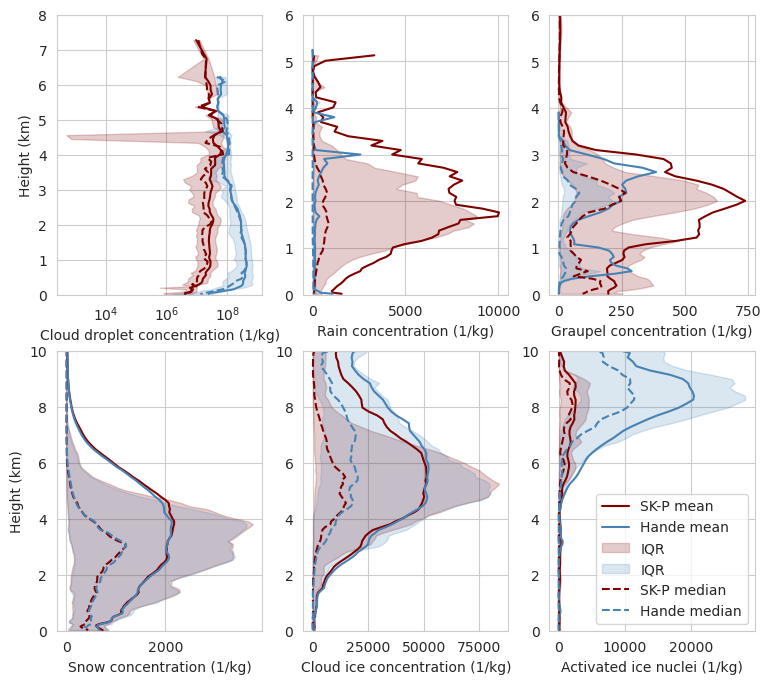

In [18]:
# make the same plot but for all variables in subplots
sns.set_style('whitegrid')

fig, ax = plt.subplots(2, 3, figsize=(9,8))

vars = ('QNC', 'QNR', 'QNG', 'QNS', 'QNI', 'NIACT')

for i, var in enumerate(vars):
    QN_v1 = ds_v1[var].where(ds_v1[var] > 1, drop=True)
    QN_v0 = ds_v0[var].where(ds_v0[var] > 1, drop=True)

    # rechunk to avoid memory error
    QN_v1 = QN_v1.chunk(dict(time=-1))
    QN_v0 = QN_v0.chunk(dict(time=-1))

    ax[i//3, i%3].plot(QN_v1.mean(dim='time', skipna=True), QN_v1['height_2']/1000, label=label_v1+" mean", color=color_v1)
    ax[i//3, i%3].plot(QN_v0.mean(dim='time', skipna=True), QN_v0['height_2']/1000, label=label_v0+" mean", color=color_v0)
    # add interquartile range
    ax[i//3, i%3].fill_betweenx(QN_v1['height_2']/1000, QN_v1.quantile(0.25, dim='time', skipna=True),
                QN_v1.quantile(0.75, dim='time', skipna=True), alpha=0.2, color=color_v1, label="IQR")
    ax[i//3, i%3].fill_betweenx(QN_v0['height_2']/1000, QN_v0.quantile(0.25, dim='time', skipna=True),
                    QN_v0.quantile(0.75, dim='time', skipna=True), alpha=0.2, color=color_v0, label="IQR")
    # add median
    ax[i//3, i%3].plot(QN_v1.median(dim='time', skipna=True), QN_v1['height_2']/1000, label=label_v1+" median", color=color_v1, linestyle='--')
    ax[i//3, i%3].plot(QN_v0.median(dim='time', skipna=True), QN_v0['height_2']/1000, label=label_v0+" median", color=color_v0, linestyle='--')
    ax[i//3, i%3].set_ylim(0, 6)

ax[0,0].set_ylim(0, 8)
ax[1,0].set_ylim(0, 10)
ax[1,1].set_ylim(0, 10)
ax[1,2].set_ylim(0, 10)

ax[0,0].set_xscale('log')
ax[1,2].legend()

ax[0,0].set_ylabel('Height (km)')
ax[1,0].set_ylabel('Height (km)')

ax[0,0].set_xlabel('Cloud droplet concentration (1/kg)')
ax[0,1].set_xlabel('Rain concentration (1/kg)')
ax[0,2].set_xlabel('Graupel concentration (1/kg)')
ax[1,0].set_xlabel('Snow concentration (1/kg)')
ax[1,1].set_xlabel('Cloud ice concentration (1/kg)')
ax[1,2].set_xlabel('Activated ice nuclei (1/kg)')

plt.savefig(figpath+'vertical_distrib/number_vertical_distrib_AO_2021.svg', dpi=300, bbox_inches='tight')

# should take around 3min but can be very long if storage is too full and many processes are running.

#### Mass mixing ratios

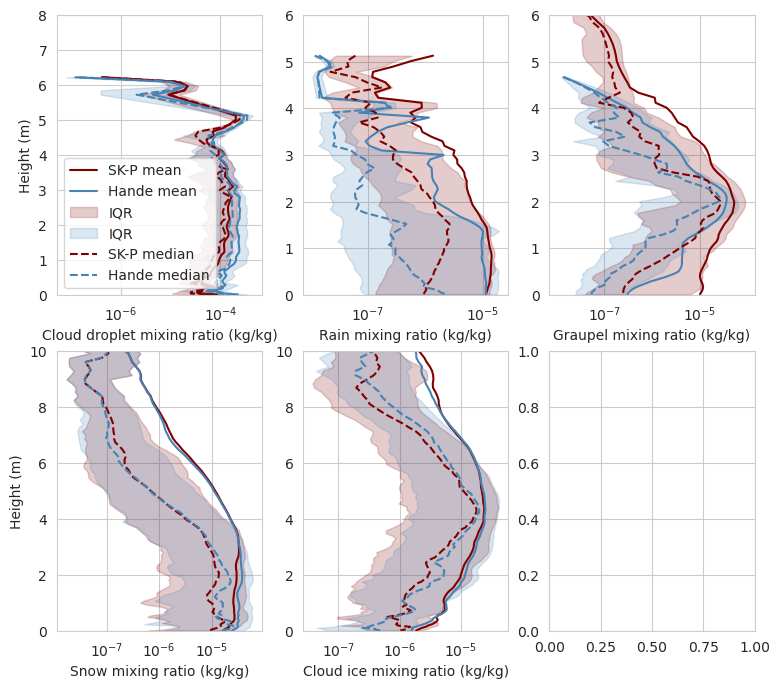

In [19]:
# make the same plot but for all variables in subplots
sns.set_style('whitegrid')

fig, ax = plt.subplots(2, 3, figsize=(9,8))

vars = ('QC', 'QR', 'QG', 'QS', 'QI')

for i, var in enumerate(vars):
    QN_v1 = ds_v1[var].where(ds_v1[var] >= 1e-8, drop=True)
    QN_v0 = ds_v0[var].where(ds_v0[var] >= 1e-8, drop=True)

    # rechunk to avoid memory error
    QN_v1 = QN_v1.chunk(dict(time=-1))
    QN_v0 = QN_v0.chunk(dict(time=-1))

    ax[i//3, i%3].plot(QN_v1.mean(dim='time', skipna=True), QN_v1['height_2']/1000, label=label_v1+" mean", color=color_v1)
    ax[i//3, i%3].plot(QN_v0.mean(dim='time', skipna=True), QN_v0['height_2']/1000, label=label_v0+" mean", color=color_v0)
    # add interquartile range
    ax[i//3, i%3].fill_betweenx(QN_v1['height_2']/1000, QN_v1.quantile(0.25, dim='time', skipna=True),
                QN_v1.quantile(0.75, dim='time', skipna=True), alpha=0.2, color=color_v1, label="IQR")
    ax[i//3, i%3].fill_betweenx(QN_v0['height_2']/1000, QN_v0.quantile(0.25, dim='time', skipna=True),
                    QN_v0.quantile(0.75, dim='time', skipna=True), alpha=0.2, color=color_v0, label="IQR")
    # add median
    ax[i//3, i%3].plot(QN_v1.median(dim='time', skipna=True), QN_v1['height_2']/1000,
                        label=label_v1+" median", color=color_v1, linestyle='--')
    ax[i//3, i%3].plot(QN_v0.median(dim='time', skipna=True), QN_v0['height_2']/1000,
                        label=label_v0+" median", color=color_v0, linestyle='--')
    ax[i//3, i%3].set_ylim(0, 6)
    ax[i//3, i%3].set_xscale('log')

ax[0,0].set_ylim(0, 8)
ax[1,1].set_ylim(0, 10)
ax[1,0].set_ylim(0, 10)

ax[0,0].legend()

ax[0,0].set_ylabel('Height (km)')
ax[1,0].set_ylabel('Height (km)')

ax[0,0].set_xlabel('Cloud droplet mixing ratio (kg/kg)')
ax[0,1].set_xlabel('Rain mixing ratio (kg/kg)')
ax[0,2].set_xlabel('Graupel mixing ratio (kg/kg)')
ax[1,0].set_xlabel('Snow mixing ratio (kg/kg)')
ax[1,1].set_xlabel('Cloud ice mixing ratio (kg/kg)')

plt.savefig(figpath+'vertical_distrib/mass_vertical_distrib_AO_2021.svg', dpi=300, bbox_inches='tight')



### 2.2 Vertical coordinate is temperature

In [85]:
# rechunk to avoid memory error
#QN_v1 = QN_v1.chunk(dict(time=-1))
#QN_v0 = QN_v0.chunk(dict(time=-1))

selvar = QN_all_hydro_v0[:,:,5][(myCLC_v0 != 0)] 
selT = T_v0_bin[selvar > 1]
selvar = selvar[selvar > 1]

median_selvar = get_median_QN(selvar, selT, T_bins)
iqr_selvar = get_iqr_QN(selvar, selT, T_bins)
mean_selvar = get_mean_QN(selvar, selT, T_bins)

print(np.max(selvar))
print(mean_selvar)


235359.58075985892
[           nan 4.97626946e+04 5.60523255e+04 5.23071958e+04
 4.08924824e+04 4.33431416e+04 4.92272241e+04 4.70990129e+04
 4.25600772e+04 3.75149912e+04 3.59693299e+04 3.04104522e+04
 2.81833378e+04 2.47758506e+04 2.45871737e+04 2.40353046e+04
 2.21592513e+04 1.97562181e+04 1.77107550e+04 1.65032907e+04
 1.48214812e+04 1.27100002e+04 1.09644029e+04 9.31579215e+03
 7.83059873e+03 6.45881045e+03 5.33488444e+03 4.42429982e+03
 3.63244949e+03 2.96535907e+03 2.35062932e+03 1.72561816e+03
 1.41005437e+03 1.12172707e+03 6.81520160e+02 6.26376975e+02
 5.16729502e+02 3.69370632e+02 2.71372093e+02 1.72198845e+02
 9.89128962e+01 5.93717073e+01 3.89503444e+01 2.94510211e+01
 2.60381879e+01 1.99272538e+01 3.61492171e+01 4.57762952e+01
 5.75790535e+01 4.03947285e+01 1.55359546e+01 5.23972203e+00
 3.75006532e+00 2.41228903e+00 2.13274534e+00 2.08146667e+00
 2.10181492e+00 2.10423212e+00 1.84706661e+00 2.33190217e+00
 3.02579465e+00 2.19169204e+00 2.04840383e+00 3.69940030e+00
 2.28

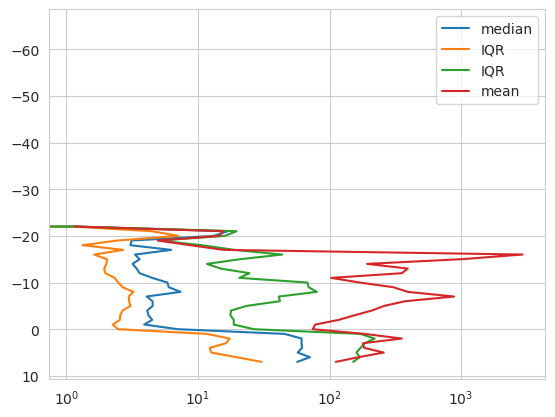

In [76]:
plt.figure()
plt.plot(median_selvar, T_bins-273, label='median')
plt.plot(iqr_selvar[:,0], T_bins-273, label='IQR')
plt.plot(iqr_selvar[:,1], T_bins-273, label='IQR')
plt.plot(mean_selvar, T_bins-273, label='mean')
plt.legend()
# reverse the y axis
plt.gca().invert_yaxis()
plt.xscale('log')
#plt.xlim(1e7, 1e9)


0
0 2218711484.6031 125518433.07443123
1
1 506320.8115046248 356335.3279579879
2
2 17006.845995091564 19798.43792169635
3
3 48061.041003283295 48686.73177836345
4
4 16524282.341754118 15118634.370926967
5
5 235359.58075985892 26559.43709208041


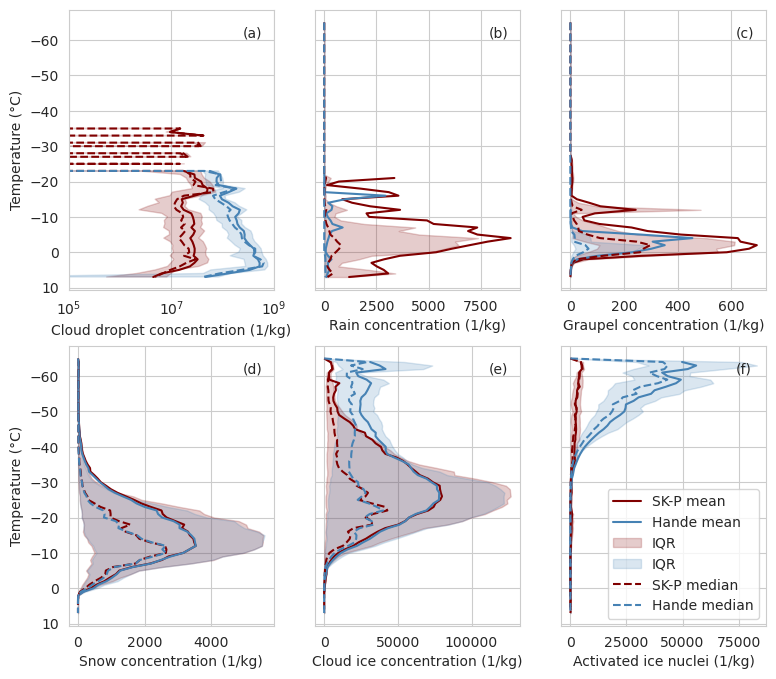

In [111]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(2, 3, figsize=(9,8))

vars = ('QNC', 'QNR', 'QNG', 'QNS', 'QNI', 'NIACT')

for i, var in enumerate(vars):
    selvar_v0 = QN_all_hydro_v0[:,:,i][(myCLC_v0 != 0)] 
    selT_v0 = T_v0_bin[selvar_v0 > 1]
    selvar_v0 = selvar_v0[selvar_v0 > 1]
    selvar_v1 = QN_all_hydro_v1[:,:,i][(myCLC_v1 != 0)]
    selT_v1 = T_v1_bin[selvar_v1 > 1]
    selvar_v1 = selvar_v1[selvar_v1 > 1]

    median_selvar_v0 = get_median_QN(selvar_v0, selT_v0, T_bins)
    iqr_selvar_v0 = get_iqr_QN(selvar_v0, selT_v0, T_bins)
    mean_selvar_v0 = get_mean_QN(selvar_v0, selT_v0, T_bins)
    median_selvar_v1 = get_median_QN(selvar_v1, selT_v1, T_bins)
    iqr_selvar_v1 = get_iqr_QN(selvar_v1, selT_v1, T_bins)
    mean_selvar_v1 = get_mean_QN(selvar_v1, selT_v1, T_bins)

    print(i)
    print(i, np.max(selvar_v0), np.max(selvar_v1))
    #print(mean_selvar_v0, mean_selvar_v1)
    # set the minimum value if it is below 1 to 0
    mean_selvar_v0[mean_selvar_v0 < 1] = 0
    mean_selvar_v1[mean_selvar_v1 < 1] = 0
    median_selvar_v0[median_selvar_v0 < 1] = 0
    median_selvar_v1[median_selvar_v1 < 1] = 0
    iqr_selvar_v0[iqr_selvar_v0 < 1] = 0
    iqr_selvar_v1[iqr_selvar_v1 < 1] = 0

    T = T_bins-273

    ax[i//3, i%3].plot(mean_selvar_v1, T, label=label_v1+" mean", color=color_v1)
    ax[i//3, i%3].plot(mean_selvar_v0, T, label=label_v0+" mean", color=color_v0)
    # add interquartile range
    ax[i//3, i%3].fill_betweenx(T, iqr_selvar_v1[:,0],
                                iqr_selvar_v1[:,1], alpha=0.2, color=color_v1, label="IQR")
    ax[i//3, i%3].fill_betweenx(T, iqr_selvar_v0[:,0],
                                iqr_selvar_v0[:,1], alpha=0.2, color=color_v0, label="IQR")
    # add median
    ax[i//3, i%3].plot(median_selvar_v1, T, label=label_v1+" median", color=color_v1, linestyle='--')
    ax[i//3, i%3].plot(median_selvar_v0, T, label=label_v0+" median", color=color_v0, linestyle='--')
    # invert y axis
    ax[i//3, i%3].invert_yaxis()
    # add subplot labels in the left corner
    ax[i//3, i%3].text(0.85, 0.9, "("+chr(ord('a') + i)+")", transform=ax[i//3, i%3].transAxes)
    if i%3 != 0:
        ax[i//3, i%3].set_yticklabels([])

ax[0,0].set_xscale('log')
ax[0,0].set_xlim(1e5,1e9)
ax[1,2].legend()

ax[0,0].set_ylabel('Temperature (°C)')
ax[1,0].set_ylabel('Temperature (°C)')

ax[0,0].set_xlabel('Cloud droplet concentration (1/kg)')
ax[0,1].set_xlabel('Rain concentration (1/kg)')
ax[0,2].set_xlabel('Graupel concentration (1/kg)')
ax[1,0].set_xlabel('Snow concentration (1/kg)')
ax[1,1].set_xlabel('Cloud ice concentration (1/kg)')
ax[1,2].set_xlabel('Activated ice nuclei (1/kg)')

plt.savefig(figpath+'AO_2021_vertical_distrib/number_temperature_distrib_AO_2021.svg', dpi=300, bbox_inches='tight')

Mass mixing ratios

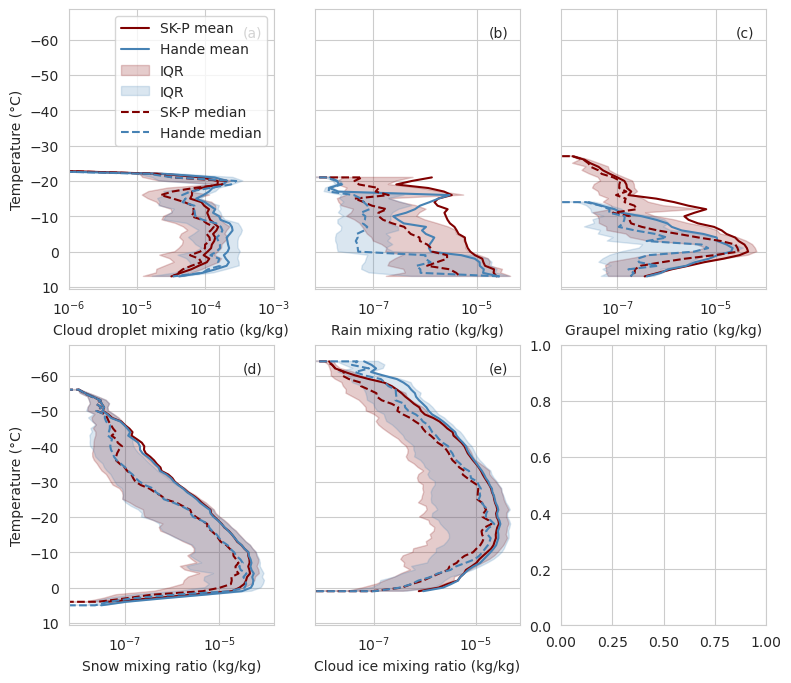

In [110]:
# make the same plot but for all variables in subplots
sns.set_style('whitegrid')

fig, ax = plt.subplots(2, 3, figsize=(9,8))

vars = ('QC', 'QR', 'QG', 'QS', 'QI')

for i, var in enumerate(vars):
    selvar_v0 = Q_all_hydro_v0[:,:,i][(myCLC_v0 != 0)] 
    selT_v0 = T_v0_bin[selvar_v0 >= 1e-8 ]
    selvar_v0 = selvar_v0[selvar_v0 >= 1e-8 ]
    selvar_v1 = Q_all_hydro_v1[:,:,i][(myCLC_v1 != 0)]
    selT_v1 = T_v1_bin[selvar_v1 >= 1e-8]
    selvar_v1 = selvar_v1[selvar_v1 >= 1e-8]

    median_selvar_v0 = get_median_QN(selvar_v0, selT_v0, T_bins)
    iqr_selvar_v0 = get_iqr_QN(selvar_v0, selT_v0, T_bins)
    mean_selvar_v0 = get_mean_QN(selvar_v0, selT_v0, T_bins)
    median_selvar_v1 = get_median_QN(selvar_v1, selT_v1, T_bins)
    iqr_selvar_v1 = get_iqr_QN(selvar_v1, selT_v1, T_bins)
    mean_selvar_v1 = get_mean_QN(selvar_v1, selT_v1, T_bins)

    T = T_bins-273
    
    ax[i//3, i%3].plot(mean_selvar_v1, T, label=label_v1+" mean", color=color_v1)
    ax[i//3, i%3].plot(mean_selvar_v0, T, label=label_v0+" mean", color=color_v0)
    # add interquartile range
    ax[i//3, i%3].fill_betweenx(T, iqr_selvar_v1[:,0], iqr_selvar_v1[:,1],
                  alpha=0.2, color=color_v1, label="IQR")
    ax[i//3, i%3].fill_betweenx(T, iqr_selvar_v0[:,0], iqr_selvar_v0[:,1],
                    alpha=0.2, color=color_v0, label="IQR")
    # add median
    ax[i//3, i%3].plot(median_selvar_v1, T,
                        label=label_v1+" median", color=color_v1, linestyle='--')
    ax[i//3, i%3].plot(median_selvar_v0, T,
                        label=label_v0+" median", color=color_v0, linestyle='--')
    ax[i//3, i%3].set_xscale('log')
    ax[i//3, i%3].invert_yaxis()
    # add subplot labels in the left corner of each subplo
    ax[i//3, i%3].text(0.85, 0.9, "("+chr(ord('a') + i)+")", transform=ax[i//3, i%3].transAxes)
    # in second and third column don't plot the xlabels
    if i%3 != 0:
        ax[i//3, i%3].set_yticklabels([])

ax[0,0].legend()
ax[0,0].set_xlim(1e-6,1e-3)

ax[0,0].set_ylabel('Temperature (°C)')
ax[1,0].set_ylabel('Temperature (°C)')

ax[0,0].set_xlabel('Cloud droplet mixing ratio (kg/kg)')
ax[0,1].set_xlabel('Rain mixing ratio (kg/kg)')
ax[0,2].set_xlabel('Graupel mixing ratio (kg/kg)')
ax[1,0].set_xlabel('Snow mixing ratio (kg/kg)')
ax[1,1].set_xlabel('Cloud ice mixing ratio (kg/kg)')

plt.savefig(figpath+'AO_2021_vertical_distrib/mass_temperature_distrib_AO_2021.svg', dpi=300, bbox_inches='tight')